# Import packages

In [1]:
import pandas as pd

import warnings 
warnings.filterwarnings(('ignore'))

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from modules.Utils.utils import loadFromDB, strategyTester


# Get Data

In [ ]:
SYMBOL= 'BTC'
df =loadFromDB(SYMBOL,'4h',True)
df.head()

In [ ]:
plt.rc('figure',figsize=(25,11))
plt.rc('font',size=15)

result = seasonal_decompose(df.Close,model='additive',extrapolate_trend='freq',)
fig = result.plot()

In [ ]:
df['Trend'] = result.trend
df['Trend_diff'] = df.Trend.diff(1)
df.dropna(inplace=True)

def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.Trend_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.Trend_diff<0 else False

strategyTester(df,buyCondition,sellCondition,equity=1000)

Testing strategy : 
Period : [2022-04-26 08:00:00] -> [2022-09-27 11:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 17673.03 $
Performance vs US Dollar : 1667.3 %
Buy and Hold Performence : -75.02 %
Performance vs Buy and Hold : -2322.56 %
Best trade : +25.09 %, the 2022-06-21 12:00:00
Worst trade : -5.08 %, the 2022-08-30 16:00:00
Worst drawBack : -11.0 %
Total fees :  1318.88 $

----- Trades Informations -----
Total trades on period : 126
Number of positive trades : 80
Number of negative trades :  46
Trades win rate ratio : 63.49 %
Average trades performance : 2.52 %
Average positive trades : 4.83 %
Average negative trades : -1.48 %

----- Plot -----


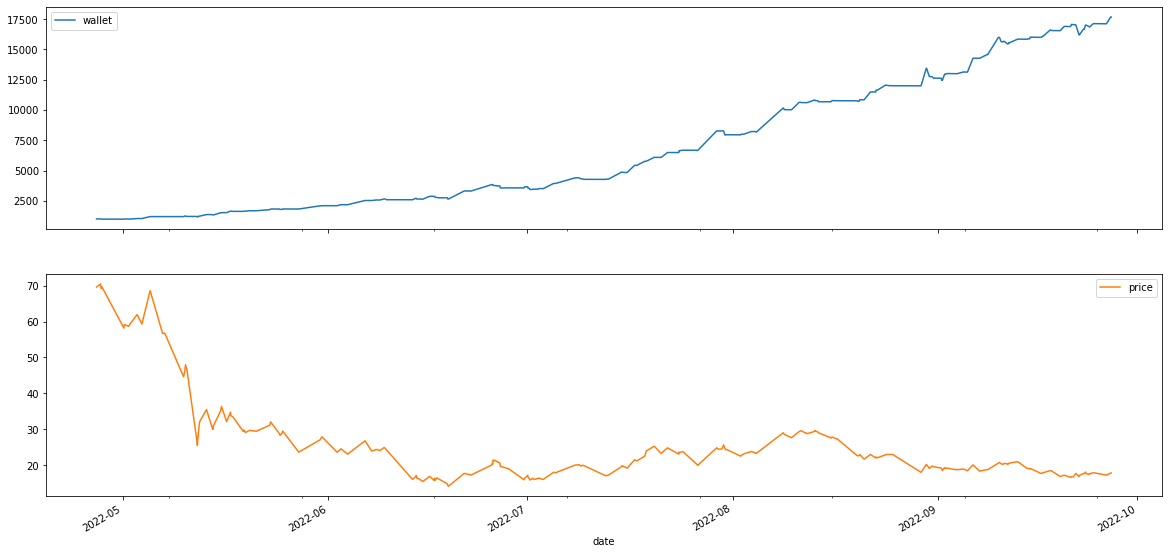

In [4]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocess import cpu_count

SYMBOL= 'AVAX'
df = loadFromDB(SYMBOL,'1h',False).iloc[-4000:]

df_final = pd.DataFrame()

def process_one_row(df_i):
    df_i['Trend'] = seasonal_decompose(df.Close,model='additive',extrapolate_trend='freq',).trend
    df_i['Trend_diff'] = df_i.Trend.diff(1)
    df.dropna(inplace=True)
    return df_i.iloc[-1]
    
with ThreadPoolExecutor(max_workers=cpu_count()) as executor:
    processes = [executor.submit(process_one_row, df.iloc[i-300:i]) for i in range(300,len(df))]

for task in as_completed(processes):
    df_final = df_final.append(task.result())
    
df_final.sort_index(inplace=True)

print('Testing strategy : ')
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.Trend_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if row.Trend_diff<0 else False

strategyTester(df_final,buyCondition,sellCondition,equity=1000)